# Classical Bayesian optimisation

In [1]:
import jax
import numpy as np
import seaborn as sns
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

from functools import partial
from jaxopt import ProjectedGradient
from rebayes_mini.methods import low_rank_last_layer as lrll

In [2]:
from bayesopt import test_functions, eval_fn

In [3]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [4]:
sns.set_palette("colorblind")
plt.rcParams["figure.figsize"] = (7.2, 4.2)

In [5]:
jnp.set_printoptions(suppress=True, precision=5, linewidth=200)

In [6]:
def plot_hist(ax, runs, color=None, **kwargs):
    steps = np.arange(len(runs[0]))
    med_run = np.quantile(runs, 0.5, axis=0)
    # med_run = np.mean(runs, axis=0)
    lbound = np.quantile(runs, 0.25, axis=0)
    ubound = np.quantile(runs, 0.75, axis=0)

    color_plot = "black" if color is None else color
    color_fill = "tab:gray" if color is None else color
    
    ax.plot(med_run, c=color_plot, **kwargs)
    ax.fill_between(steps, lbound, ubound, color=color_fill, alpha=0.4)

In [7]:
key = jax.random.PRNGKey(314)
key_init_params, key_run = jax.random.split(key)

## Hartmann function

In [24]:
def objective_fn(x):
    return -test_functions.hartmann6(x)
x_opt = jnp.array([0.20169, 0.150011, 0.476874, 0.275332, 0.311652, 0.6573])
dim = len(x_opt)
print(objective_fn(x_opt))

3.322363


In [137]:
def objective_fn(x):
    return -test_functions.ackley(x, lbound=-5.0, ubound=10.0)
x_opt = jnp.zeros(5)
dim = len(x_opt)
print(objective_fn(x_opt))

-12.642424


In [153]:
surrogate = eval_fn.MLPSurrogate()
params_init = surrogate.init(key_init_params, x_opt)

def cov_fn(y): return 0.0 # Function interpolation does not require observation noise
agent = lrll.LowRankLastLayer(
    surrogate.apply, cov_fn, rank=30, dynamics_hidden=0.0, dynamics_last=0.0,
)

bel_init = agent.init_bel(
    params_init,
    cov_hidden=1e-4, # parameters do not vary much from their initial parameters
    cov_last=3.0, # uncertainty in target
    low_rank_diag=True,
)

In [154]:
%%time
n_steps = 100
n_runs = 1 # choose 20
lbound, ubound = 0.0, 1.0
keys = jax.random.split(key_run, n_runs)
runs = eval_fn.test_runs(keys, n_steps, agent, bel_init, objective_fn, dim, lbound, ubound, dim)
runs = jax.tree.map(np.array, runs)
bel_runs = runs[0]
runs = runs[1]

CPU times: user 8.62 s, sys: 261 ms, total: 8.88 s
Wall time: 7.44 s


Text(0.5, 0, 'iteration')

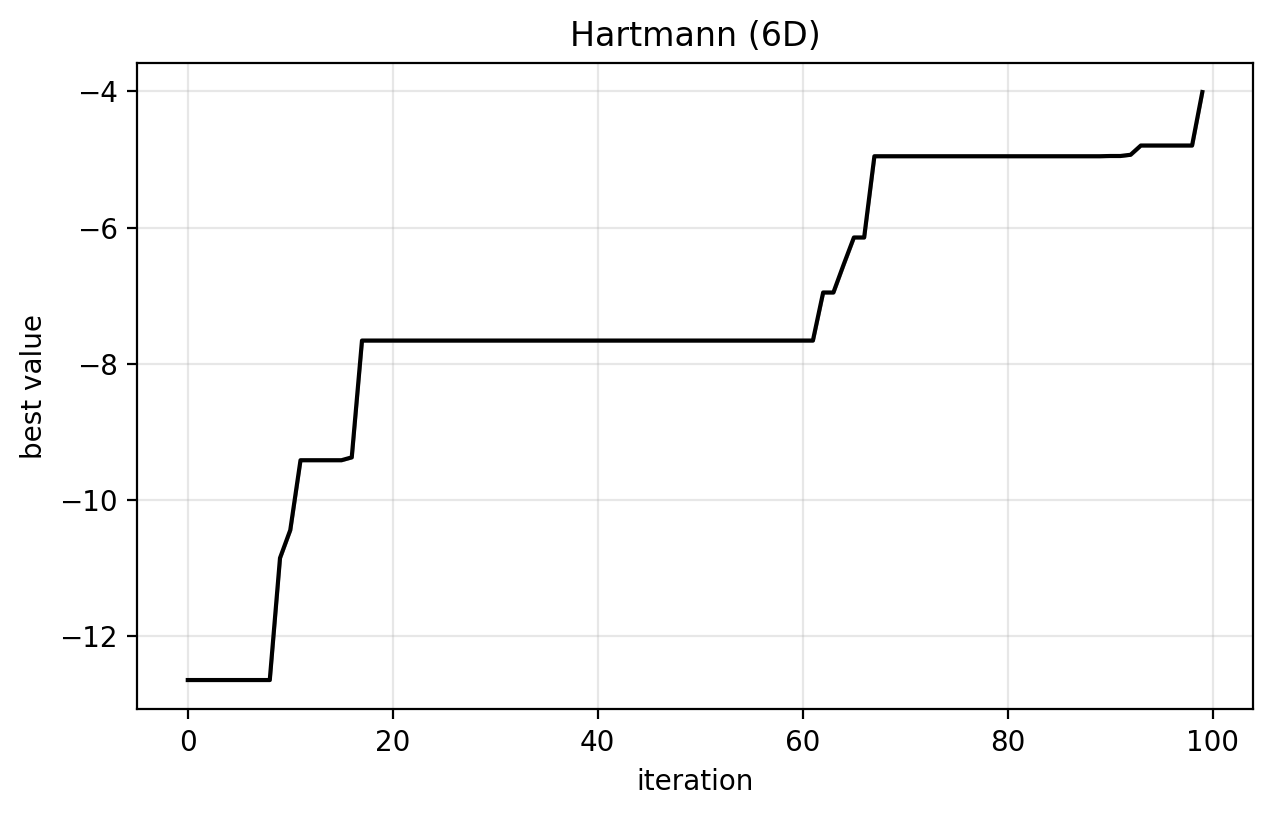

In [155]:
fig, ax = plt.subplots()
plot_hist(ax, runs)
plt.grid(alpha=0.3)
plt.title("Hartmann (6D)")
plt.ylabel("best value")
plt.xlabel("iteration")
# plt.xticks(np.arange(0, 110, 10));